# <center>MDC Capstone
## <center>Sentiment Analysis and Sk-LLM
### <center>By Joemichael Alvarez

___Dataset:___ `reviews.csv`:
[Here](https://github.com/AlvarezJoe/Datasets/blob/main/reviews.csv)

___Dataset Information:___
* __Number of instances 10743__
* __Number of Attributes 4__
* __Missing Attribute Values None__

___Attribute Information:___
* __CompanyName__--qualitative--Refers to the comapny referred to in the review--Subsidiaries were overwritten with the parent company.
* __Review__--qualitative--The review itself--Cleaned of any non-ASCII characters
* __Date__--The date the review was posted--Standardized with datetime
* __OwnershipType__--The type of company--Falls under one of three types: Privately Owned, Publicly Traded, or Non-Profit
* __ReviewLen__--The length of the review--Created to get a better idea of the kind of reviews are being submitted
* __AvgSentenceLen__--The average length of sentences per review--Created to see how sentence length can alter in our responses

_For more info on the webscraping process check out my other google collab [here](https://colab.research.google.com/drive/1a7vwG5fKly2cS-9i9kmRZbT1ZLbZ4QQK?usp=sharing)._

# Defining Our Problem

Healthcare companies provide services to millions of Americans every year. Yet there seems to be a lack of communication on the part of their clients. For every business in America, we compare our options. Booking a flight, we compare our options. Why is it that when it comes to selecting a healthcare provider, we do not compare our options, and if we do it is through the tedious process of going plan to plan hoping the next plan is better than the previous one. Why are the providers themselves not accountable for the doctors in their service, the plan they provide, or the customer service experience.

In my search I have found websites to compare doctors and plans, but few websites even bother to discuss the posibility that the provider is important too.To remedy this I found a website that lists reviews for healthcare providers (which was rather difficult to locate) and webscraped the data to begin a sentiment analysis on healthcare providers.

Another tool I'll be employing is a new library called Sk-LLM. This library has come out in tandem with the rapid growth of large language models (LLMs). Perhaps using Sk-LLM we can cut down on the noise of reviews and get more definitive answers on which healthcare companies proved great service to their customers.

# Instillations

In [ ]:
!pip install scikit-llm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Libraries

In [ ]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from skllm.config import SKLLMConfig
from skllm.preprocessing import GPTSummarizer
from google.colab import files

#quality of life
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
#requirements.txt
!pip freeze > requirements.txt

In [ ]:
#api key and org id
SKLLMConfig.set_openai_key("OPENAI-API-KEY")
SKLLMConfig.set_openai_org("OPENAI-ORG-ID")

# EDA

In [ ]:
#load the data
reviews_df = pd.read_csv("https://raw.githubusercontent.com/AlvarezJoe/Datasets/main/reviews.csv")
reviews_llm45_df = pd.read_csv("https://raw.githubusercontent.com/AlvarezJoe/Datasets/main/reviews_llm45.csv")
reviews_llm90_df = pd.read_csv("https://raw.githubusercontent.com/AlvarezJoe/Datasets/main/reviews_llm90.csv")

In [ ]:
#display info
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10766 entries, 0 to 10765
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CompanyName     10766 non-null  object 
 1   Review          10764 non-null  object 
 2   Date            10766 non-null  object 
 3   OwnershipType   10766 non-null  object 
 4   ReviewLen       10766 non-null  int64  
 5   AvgSentenceLen  10766 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 504.8+ KB


In [ ]:
#checking for nulls
missing_data = reviews_df.isnull()

#prints no missing values for all columns unless nulls exist
for column in missing_data.columns.values.tolist():
  if missing_data[column].sum() != 0:
    print(column, "-", missing_data[column].sum(), "missing values")
    print("")
  else:
    print(column,"has no missing values\n")

CompanyName has no missing values

Review - 2 missing values

Date has no missing values

OwnershipType has no missing values

ReviewLen has no missing values

AvgSentenceLen has no missing values



Not sure how these nulls got through. Let's remove them.

In [ ]:
#drop nulls
reviews_df = reviews_df.dropna()

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10764 entries, 0 to 10765
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CompanyName     10764 non-null  object 
 1   Review          10764 non-null  object 
 2   Date            10764 non-null  object 
 3   OwnershipType   10764 non-null  object 
 4   ReviewLen       10764 non-null  int64  
 5   AvgSentenceLen  10764 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 588.7+ KB


In [ ]:
#show the first few records
reviews_df.head()

,CompanyName,Review,Date,OwnershipType,ReviewLen,AvgSentenceLen
0,united_american,"I've been with United American Insurance for lots of years and I just pay my bill every month. Once a year, I get a letter that they're increasing their rates, which I would prefer they didn't, but I can understand that it has to. A lot of my friends have HMOs but I like that with my insurance, I can go to whichever doctor I want. I've not had one doctor say they don't accept this insurance. Whatever Medicare paid, United American Insurance paid the other 20%. I am pleased with the service I'm getting, where everything is covered and the choices are mine. Others have to go for a second opinion but I don't. If I feel I need to see a special doctor, I can make an appointment and go. So, the flexibility is worth the money.",2023-05-11,Public,729,40.50
1,united_american,"United American has been fantastic. We have had not one bit of trouble collecting or paying for anything at all. So, we're extremely happy. I've had a lot of illnesses so many times and when you had as much as I've had, you get canceled pretty quickly by other companies. But United have not questioned and they have been unbelievable. We are very fortunate to have gotten them. We pay quite a bit, but it's worth the cost. When I was very ill on sepsis and pancreatic stones, I was in the hospital for 15 days and they were no questions asked. In the last few years, I've had treatments for my breast cancer and there were no questions about that either.",2023-04-22,Public,655,36.39
2,united_american,"We've had very good luck with United American. We got it in 2001 and we have used it. My husband had open heart surgery quite a few years ago. Now, there was a discrepancy. I was just hospitalized from an accident on the farm here and we had a little problem, but it was more of the hospital. They kept saying I still owed $1,500. When we called United American, they said no, they had mailed a check. Somewhere, the check must have gotten lost, so they were going to rebill them again. But that was the only time that I had a problem. We're very satisfied with what we've got and our experience with it has been very good.",2022-10-28,Public,623,34.61
3,united_american,"We've had a United American Insurance policy for a long time, and the coverage has been excellent. It's like someone sweeping then someone picking up the filings with a magnet. It's very complete. We also get the mailings showing what has been paid. At one time, we had a rep, but I have never had to call customer service, because everything seemed to be always completed. Ever since we went on Medicare, we've enjoyed the service, and we've never had any reason to even contact anyone. UAI is fabulous, and I'd recommend it to anyone. It's not inexpensive, but when it comes right down to it, it's worth every penny. I just had some major surgery and I haven't seen a bill from it.",2022-10-12,Public,683,37.94
4,united_american,"We were with Cleveland Clinic and when they stopped taking HMO, United American Insurance was there to pick up the pieces. I've had them ever since and they've always been extremely good with me. When I asked them a question, they gave me an answer. They've been fair too and I have never had anybody question me. All this time, I've had three back surgeries and two other major surgeries. I've never had them deny a claim that I had to go back for. Sometimes United American Insurance is a little more expensive than HMO. But they have the same things as an HMO. I had to have my eyes examined and they do a refractory that insurances don't pay for. A gentleman went too and he had insurance for the eyes. He gave a card and was told, “We're sorry, we don't take that anymore because they don't pay their bills.” I have never had anyone tell me they wouldn't take United American Insurance.",2022-09-01,Public,891,49.50


# Feature Creation

In the Sk-LLM Reviews section you'll notice that the code is commented out. The reason is simple, in order to remove the OpenAI API key and not need to continue reloading the data as I work and experiment in this collab, I've included the columns as part of reviews.csv on my Git.

## Sk-LLM Reviews

In [ ]:
#checking the length of reviews using words
#reviews_df['WordsPerReview'] = reviews_df['Review'].str.split().apply(len)

#reviews_df['WordsPerReview'].head()

In [ ]:
#average words per review
#reviews_df['WordsPerReview'].mean()

Since the average review has about 180 words we'll be making two more reviews with Sk-LLM, one with 90 words in it and another with 45 words in it. We'll be placing them in their own dataframes to perform subjectivity and polarity on them with Textblob. We'll use only 500 records otherwise this process would take ~6 hours each in a collab environment.

In [ ]:
#different metrics for model
#gpts90 = GPTSummarizer(openai_model="gpt-3.5-turbo", max_words=90)
#gpts45 = GPTSummarizer(openai_model="gpt-3.5-turbo", max_words=45)

In [ ]:
#only 500 reviews
#rev = reviews_df['Review'].values[:500]

In [ ]:
#create llm90
#reviews_llm90_df = pd.DataFrame(gpts90.fit_transform(rev), columns = ['Review'])

#reviews_llm90_df.head()

In [ ]:
#create llm45
#reviews_llm45_df = pd.DataFrame(gpts45.fit_transform(rev), columns = ['Review'])

#reviews_llm45_df.head()

During this process there were some errors, but they were infrequent. Ultimately it appears that all 500 reviews came unscaved through the process. In order to minimize the amount of times we have to run this code (it not only costs money but takes quite a bit of time, hence the 500) we'll be creating some csv's and uploading them to Git.

In [ ]:
#create csv for llm90
#reviews_llm90_df.to_csv('reviews_llm90.csv', index=False)

In [ ]:
#create csv for llm45
#reviews_llm45_df.to_csv('reviews_llm45.csv', index=False)

In [ ]:
#download both
#files.download('reviews_llm90.csv')
#files.download('reviews_llm45.csv')

We'll also be needing our metrics for sentiment. For this we'll be using Textblob.

## Subjectivity and Polarity

In [ ]:
#create subjective and polarity columns
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [ ]:
#get polarity with a function
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
#create subjective and polarity columns
reviews_df['Subjectivity'] = reviews_df['Review'].apply(getSubjectivity)
reviews_df['Polarity'] = reviews_df['Review'].apply(getPolarity)

In [ ]:
#create subjective and polarity columns for llm90
reviews_llm90_df['Subjectivity'] = reviews_llm90_df['Review'].apply(getSubjectivity)
reviews_llm90_df['Polarity'] = reviews_llm90_df['Review'].apply(getPolarity)

In [ ]:
#create subjective and polarity columns for llm45
reviews_llm45_df['Subjectivity'] = reviews_llm45_df['Review'].apply(getSubjectivity)
reviews_llm45_df['Polarity'] = reviews_llm45_df['Review'].apply(getPolarity)

You can adjust the values for getAnalysis if you prefere a more tight or flexible definition for Negative, Positive, and Neutral.

In [ ]:
#create a function to check negative, neutral and positive analysis
def getAnalysis(score):
    if score<-.05:
        return 'Negative'
    elif score>.05:
        return 'Positive'
    else:
        return 'Neutral'

In [ ]:
#create analysis column
reviews_df['Analysis'] = reviews_df['Polarity'].apply(getAnalysis)

In [ ]:
#create analysis column for llm45
reviews_llm45_df['Analysis'] = reviews_llm45_df['Polarity'].apply(getAnalysis)

In [ ]:
#create analysis column for llm90
reviews_llm90_df['Analysis'] = reviews_llm90_df['Polarity'].apply(getAnalysis)

Now that we have subjectivity, polarity, and analysis, let's begin our sentiment analysis on our dataset.

# Sentiment Analysis

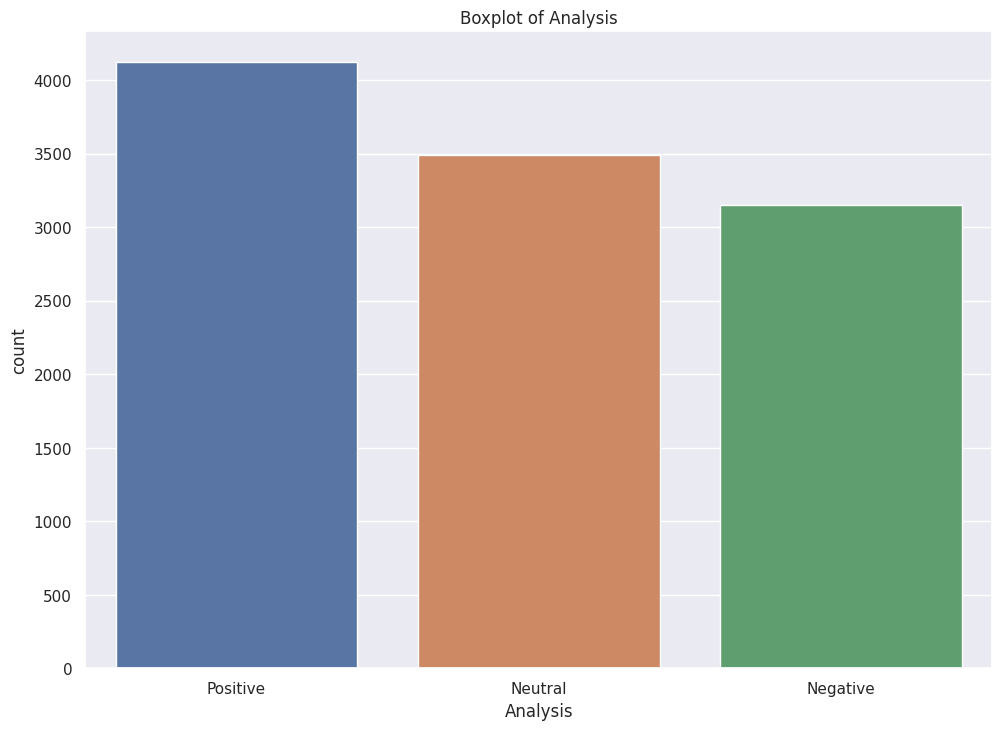

In [ ]:
#boxplot for analysis
plt.figure()
sns.countplot(data=reviews_df, x="Analysis", order=reviews_df['Analysis'].value_counts().index)
plt.title("Boxplot of Analysis")
plt.show()

Looks like the vast majority of reviews are on the positive side with neutral at second and negative dead last. Let's normalize it and see the distribution.

In [ ]:
#normalized analysis column
reviews_df['Analysis'].value_counts(normalize=True)

Positive    0.383129
Neutral     0.324043
Negative    0.292828
Name: Analysis, dtype: float64

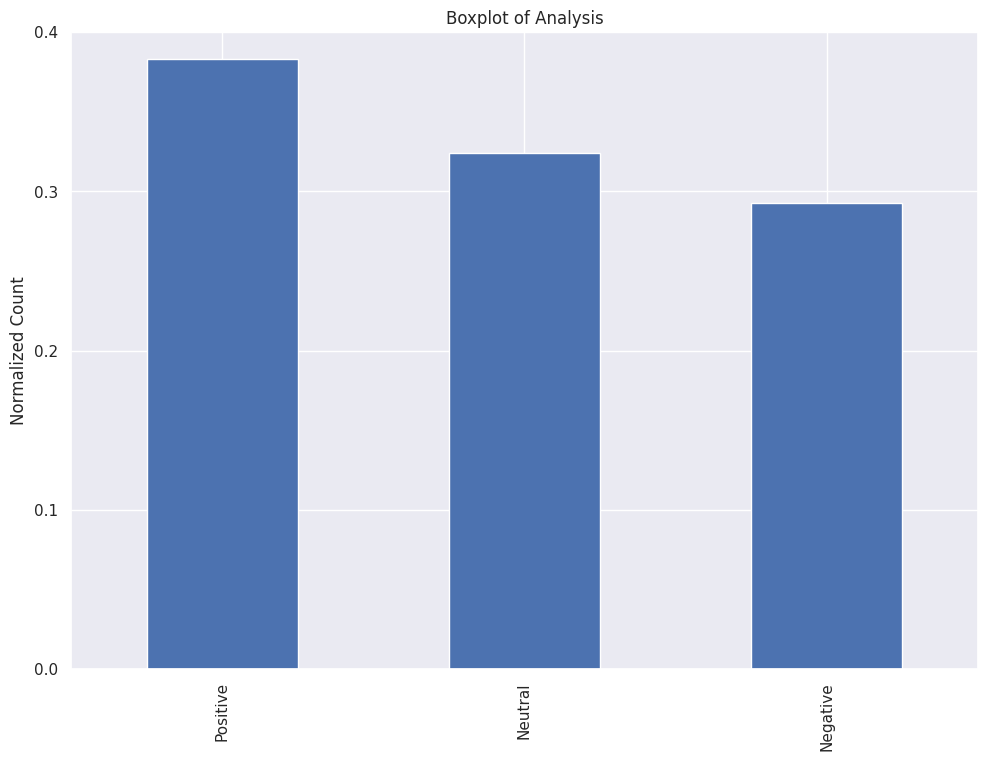

In [ ]:
#comparing the box plots normalized
plt.figure()
(reviews_df['Analysis'].value_counts(normalize=True)).plot(kind='bar')
plt.title("Boxplot of Analysis")
plt.ylabel("Normalized Count")
plt.ylim(0, .4)
plt.yticks(np.arange(0, .5, .1))
plt.show()

The majority of reviews are positive. Thats a win in my book. It's good to see that the majority of recorded interactions with healthcare providers is positive.

## Correlation Matrix

<ipython-input-266-964d8107f6cf>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = reviews_df.corr()


<Axes: >

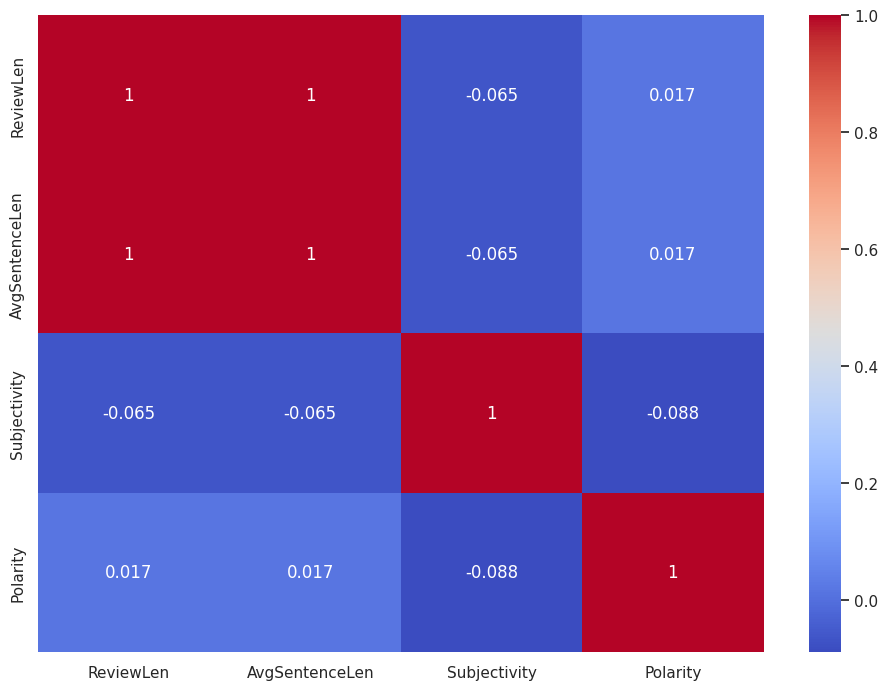

In [ ]:
#correlation matrix for dataframe
corr = reviews_df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

Well thats very intersting. It appears that the polarity of the review has little to do with the subjectivity nor the length of the review.

It also seems interesting that there is a 100% correlation between the average sentence length and the average review length. The more someone is willing to write, the more their sentences go from short to long. I'm sure there's something there for psychologists to go over.

## Ownership Type

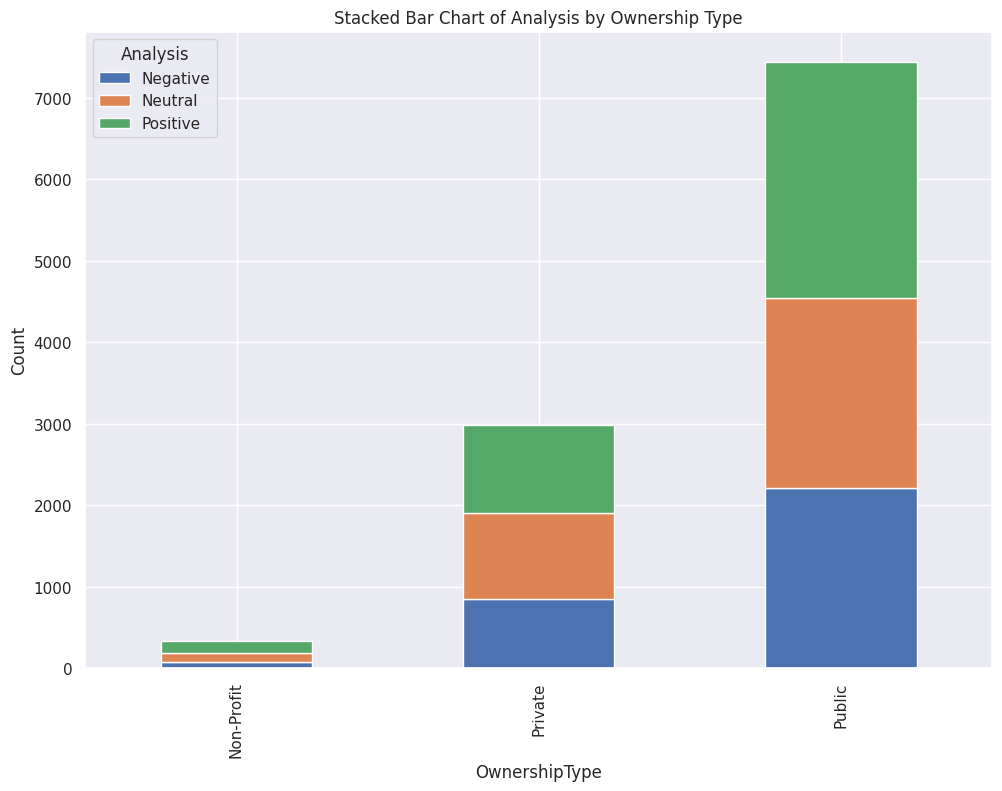

In [ ]:
#group by CompanyType and Analysis
grouped = reviews_df.groupby(['OwnershipType', 'Analysis']).size().unstack()

#plot stacked bar chart
grouped.plot(kind='bar', stacked=True)

#title and count
plt.title("Stacked Bar Chart of Analysis by Ownership Type")
plt.ylabel("Count")
plt.show()

Not very non-profit company reviews. It seems that the majority of our reviews come from publicly traded companies.

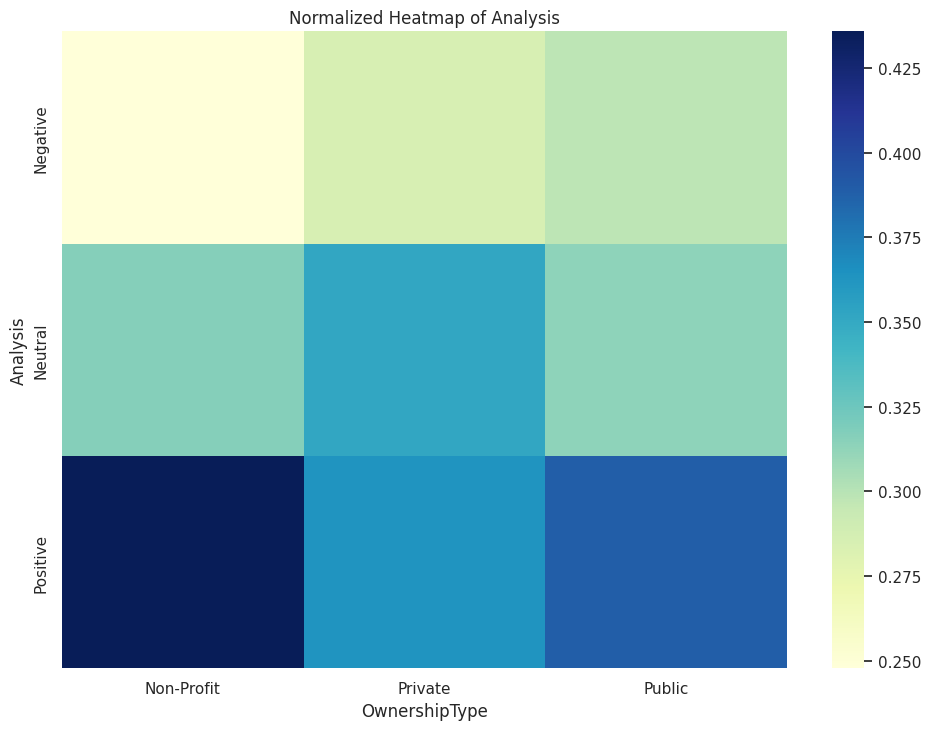

In [ ]:
#polarization count normalized
plt.figure()
sns.heatmap(pd.crosstab(reviews_df['Analysis'], reviews_df['OwnershipType'], normalize='columns'), cmap="YlGnBu")
plt.title("Normalized Heatmap of Analysis")
plt.show()

The addage that the majority of people leaving reviews are leaving reviews being negative or positive falls a bit short for us.

 Comparitavely it seemse that non-profits recieve the least of negative reviews. Perhaps with more datapoints the non-profits will level out with the rest.

 Privately owned companies seem to have the worst ratios of positive to negative reviews.

## Date

In [ ]:
#month of review
reviews_df['ReviewMonth'] = reviews_df['Date'].apply(lambda x: x.split("-", 2)[1])
reviews_df['ReviewMonth'].head()

0    05
1    04
2    10
3    10
4    09
Name: ReviewMonth, dtype: object

In [ ]:
#year of review
reviews_df['ReviewYear'] = reviews_df['Date'].apply(lambda x: x.split("-", 2)[0])
reviews_df['ReviewYear'].head()

0    2023
1    2023
2    2022
3    2022
4    2022
Name: ReviewYear, dtype: object

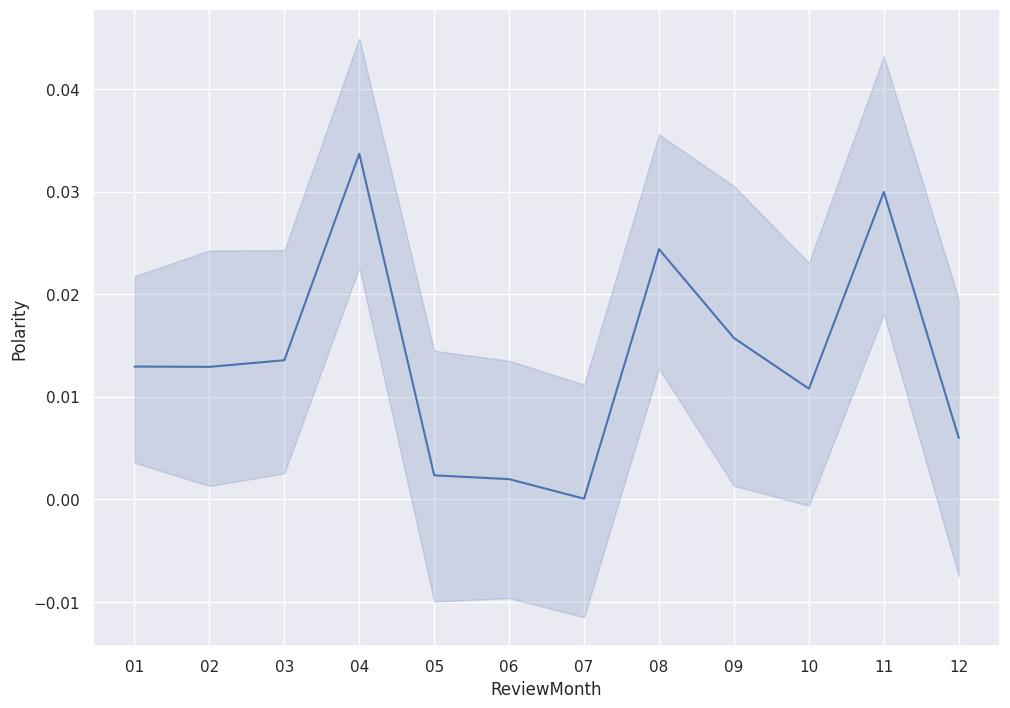

In [ ]:
#polarity per month
sns.set_style('darkgrid')
sns.lineplot(data=reviews_df.sort_values('ReviewMonth'), x='ReviewMonth', y='Polarity')
plt.show()

I wouldn't necessarily say that there is any specific conclusions to be made using month. It seems mostly random.

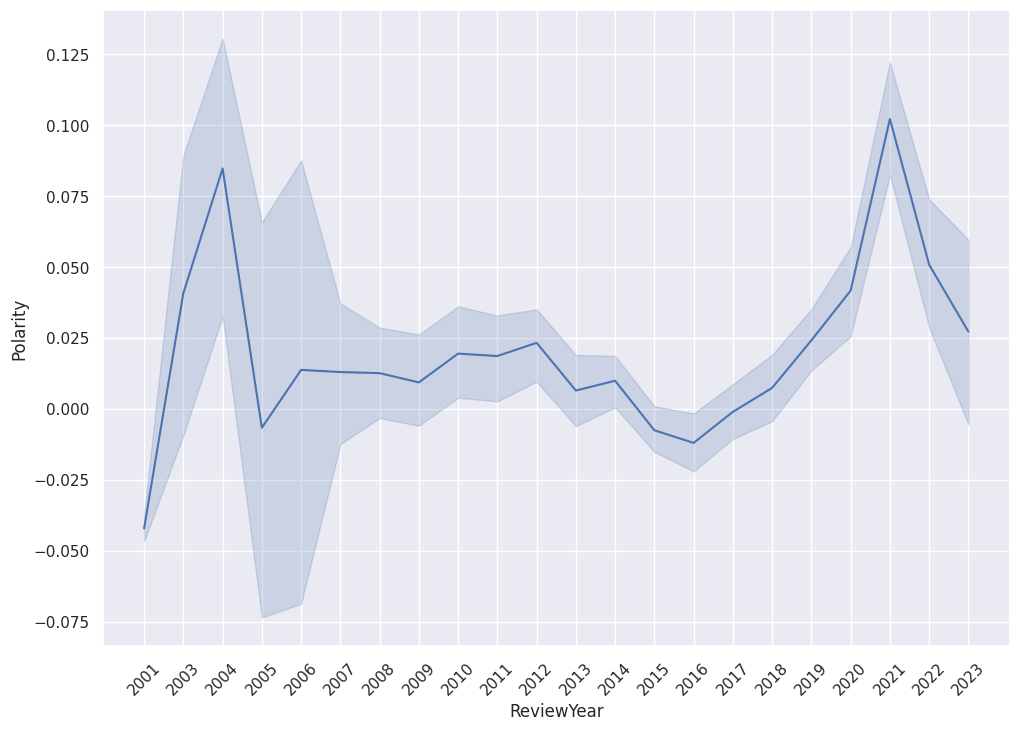

In [ ]:
#polarity per year
sns.set_style('darkgrid')
sns.lineplot(data=reviews_df.sort_values('ReviewYear'), x='ReviewYear', y='Polarity')
plt.xticks(rotation=45)
plt.show()

Unlike month there is definitely more to look at here. There is much more stability after 2010 when it comes to variance in polarity. More likely than not it has to do with the number of reviews we have for that time slot. We'll inspect that after.

It also seems that leading up to 2017 opinions were fairly neutral when it came to healthcare, but as we moved into 2021 sentiment became very positive. Unfortunately we are now experiencing a sharp decline in sentiment. The reason for the rise and fall of this should be investigated. Did market conditions shift? Did a shift in law cause newfound confidence in these companies?

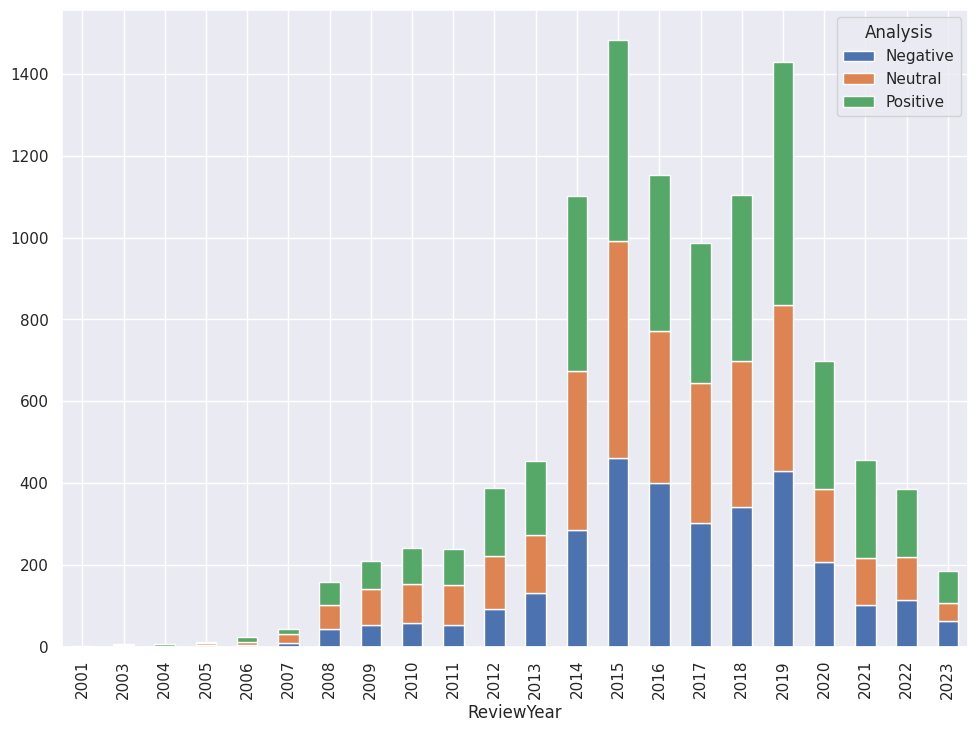

In [ ]:
#stacked bar chart of analysis per year
analysis_count = reviews_df.groupby(reviews_df['ReviewYear'])['Analysis'].value_counts()
analysis_count = analysis_count.unstack()
ax = analysis_count.plot(kind='bar', stacked=True)
plt.show()

This mostly confirms our earlier suspicions that our overall count of reviews skyrocketed from 2010 on. It's rather strange how different those years are though. Especially considering that overall traffic to this website has declined so heavily as to affect the amount of reviews being posted. Could the creation of healthcare.gov have decreased the amount of reviews being posted?

## Company Name

Arguably our most important conclusions should be found below. After all the purpose of our analysis is not only to highlight the lack of review for these companies, but also to find the companies to avoid amongst them all.

In [ ]:
#create a dataframe to better highlight the quality of each of there companies
avg_polarity = pd.DataFrame(reviews_df.groupby('CompanyName')['Polarity'].mean())

total_count = reviews_df['CompanyName'].value_counts()

company_type = reviews_df.groupby('CompanyName')['OwnershipType'].unique()

company_analysis = avg_polarity

company_analysis['TotalCount'] = total_count

company_analysis['OwnershipType'] = company_type

company_analysis.sort_values('Polarity', ascending=False)

,Polarity,TotalCount,OwnershipType
CompanyName,,,
united_american,0.199742,391,[Public]
highmark,0.085690,46,[Non-Profit]
aarp_health,0.022000,131,[Non-Profit]
anthem,0.015519,615,[Private]
kaiser,0.013213,1261,[Private]
carefirst,0.010460,83,[Non-Profit]
humana,0.009875,1798,[Public]
aetna_health,0.009863,1118,[Public]
ihc_health_solutions,0.007982,75,[Non-Profit]


As you can clearly see non-profits, although a minority of reviews, all are viewed in a positive light. Our poorly reviewed companies are wellcare, amerihealth, and healthnet. To me Kaiser is the largest standout among its peers. Despite being massively reviewed and private, it is in a solid position.

<Axes: xlabel='count', ylabel='Analysis'>

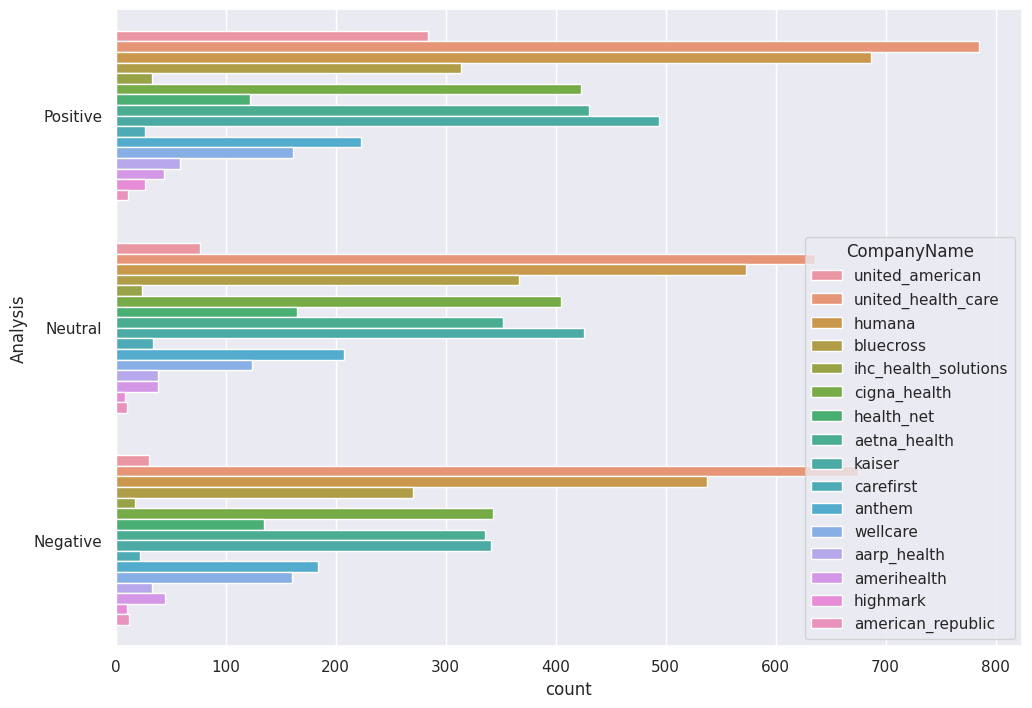

In [ ]:
#analysis count for all companies
#unfortunately this undervalues smaller companies despite being good overall companies
sns.countplot(y='Analysis', hue='CompanyName', data=reviews_df)

While this is nice let's go company by company to compare the total amount of positive/neutral/negative reviews.

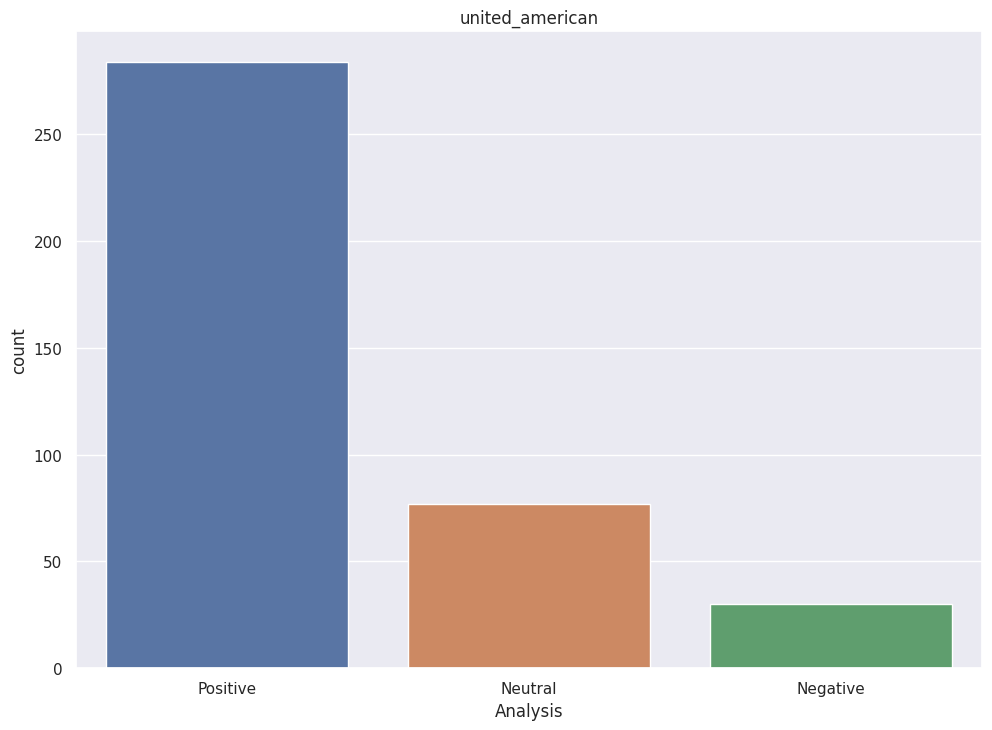

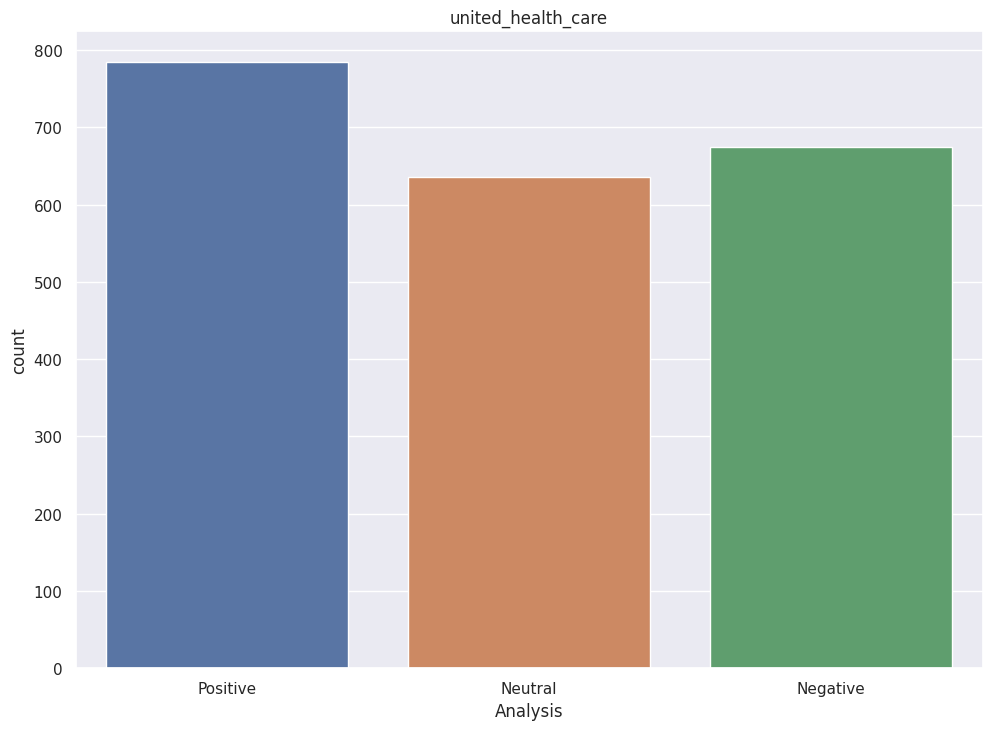

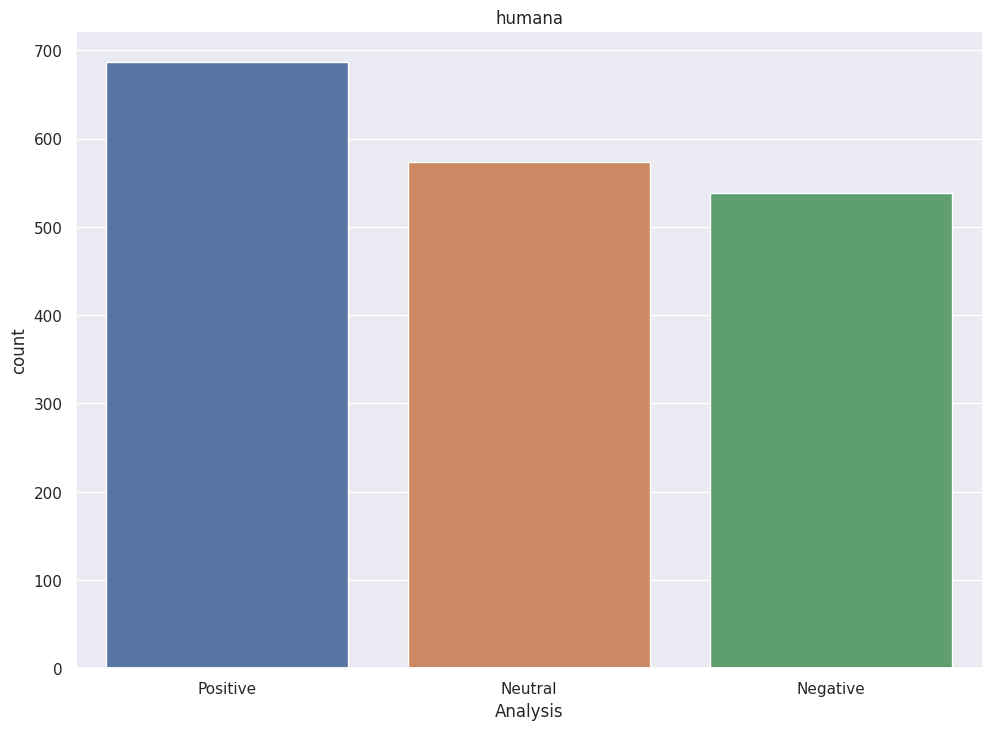

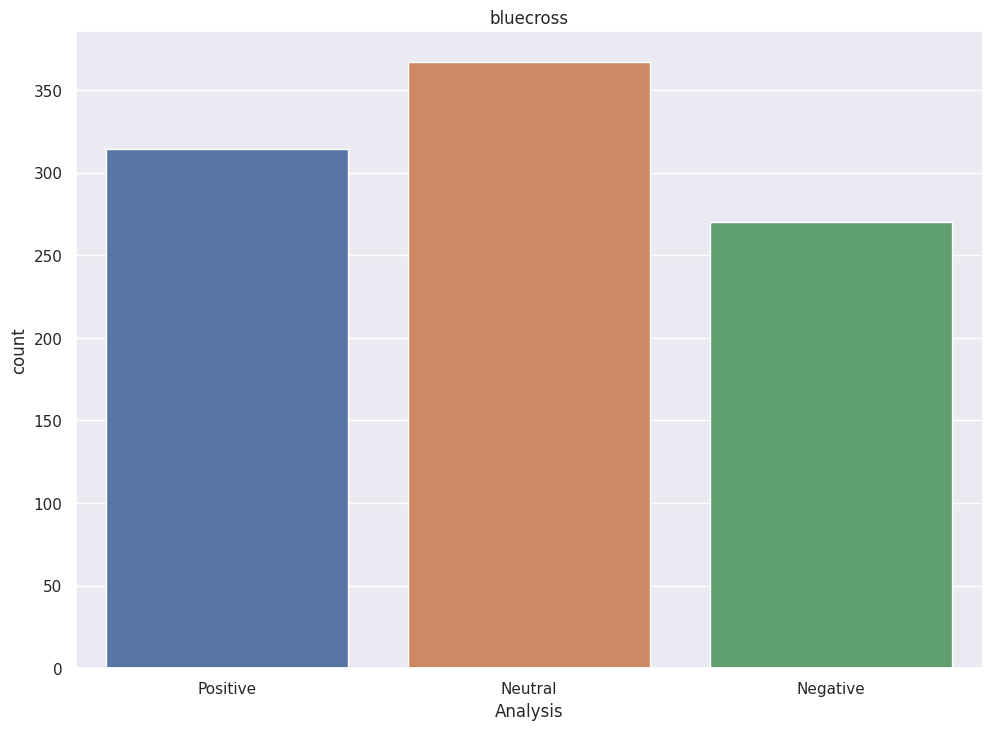

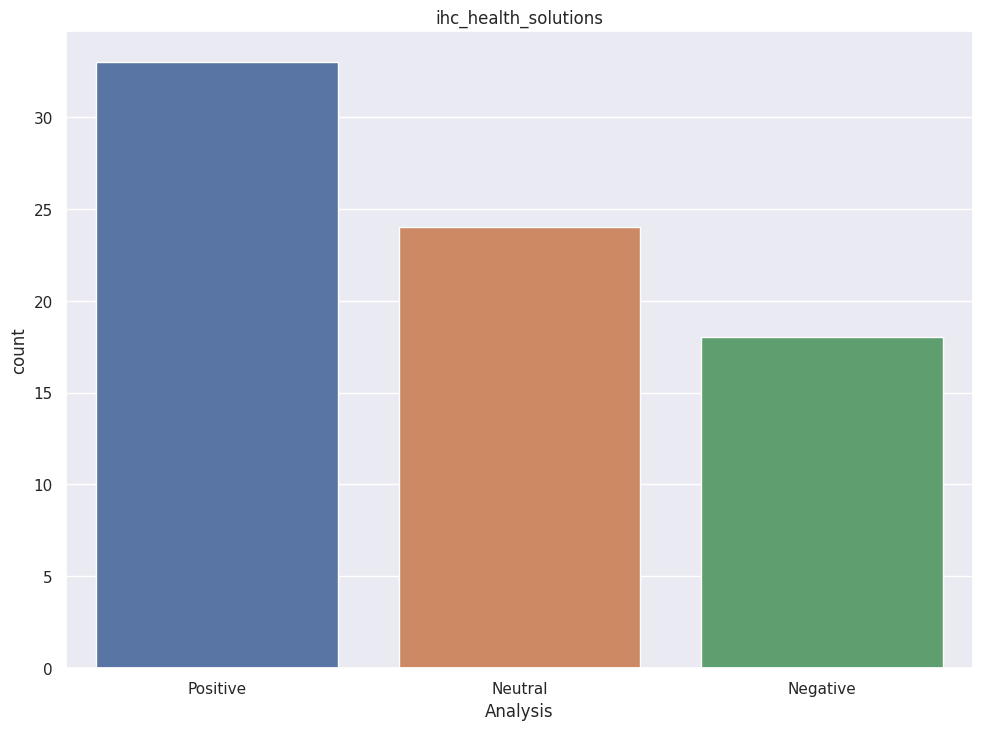

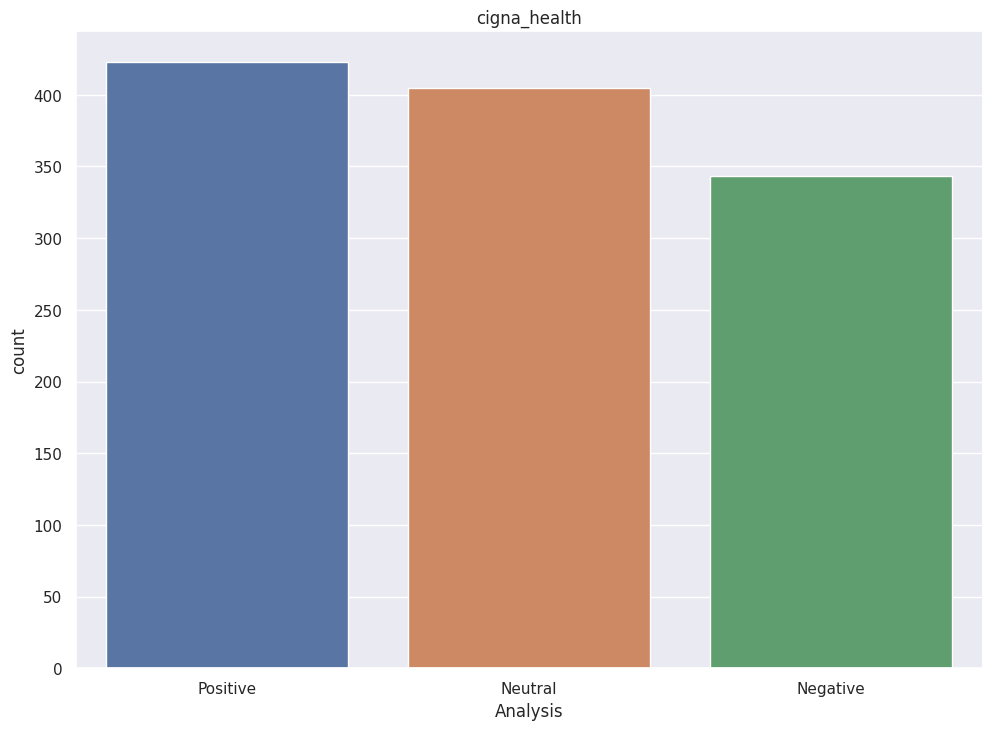

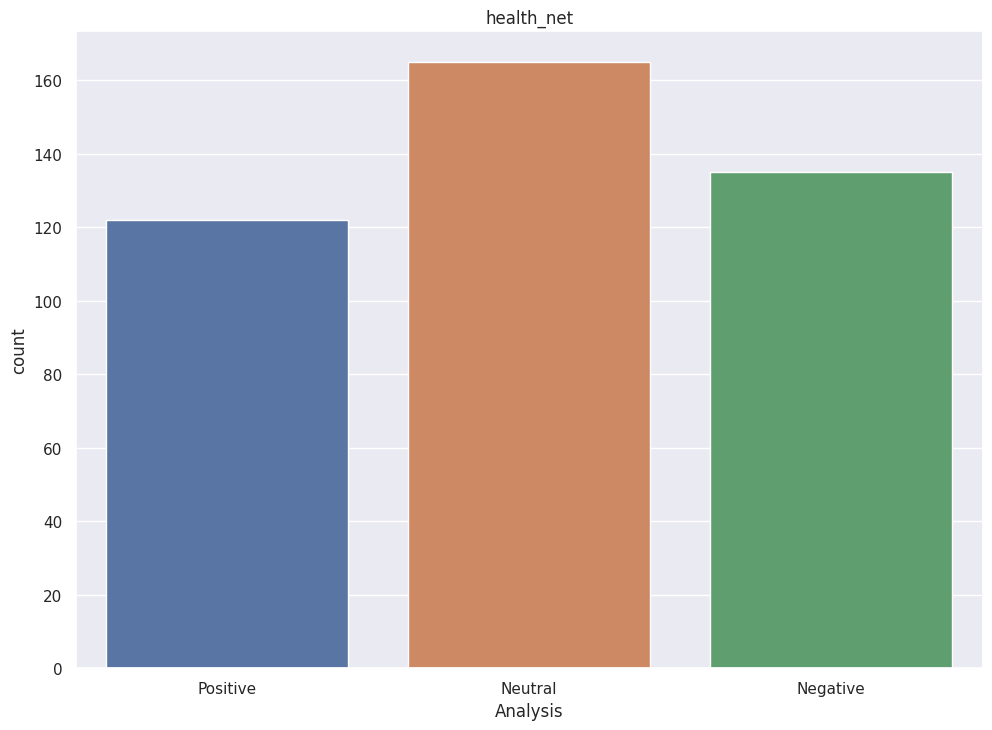

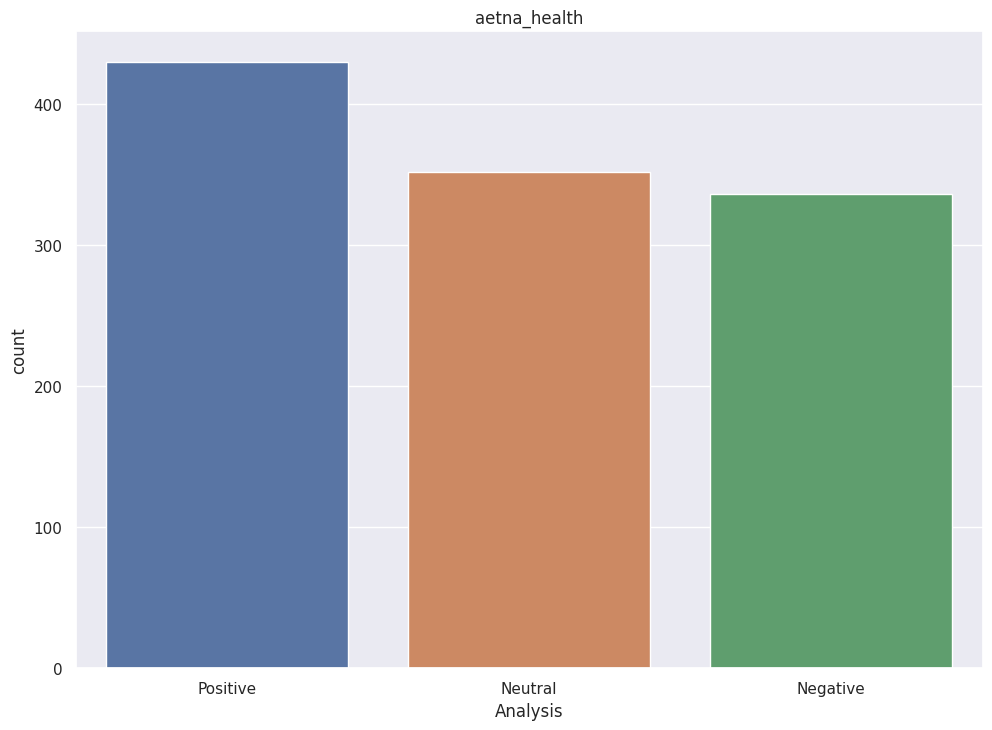

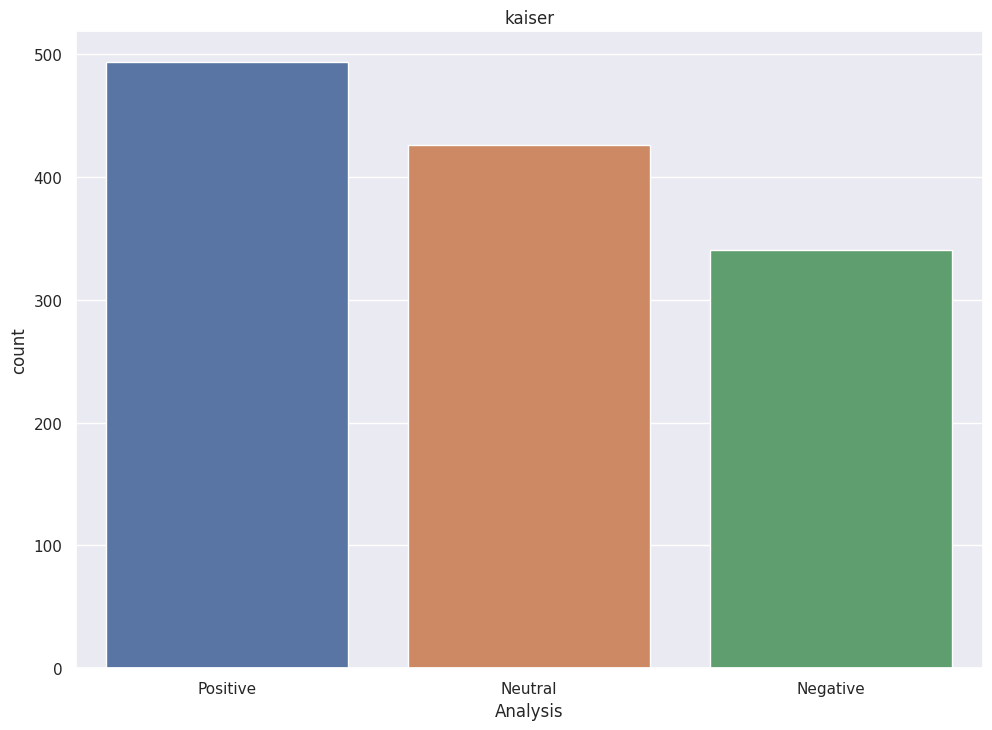

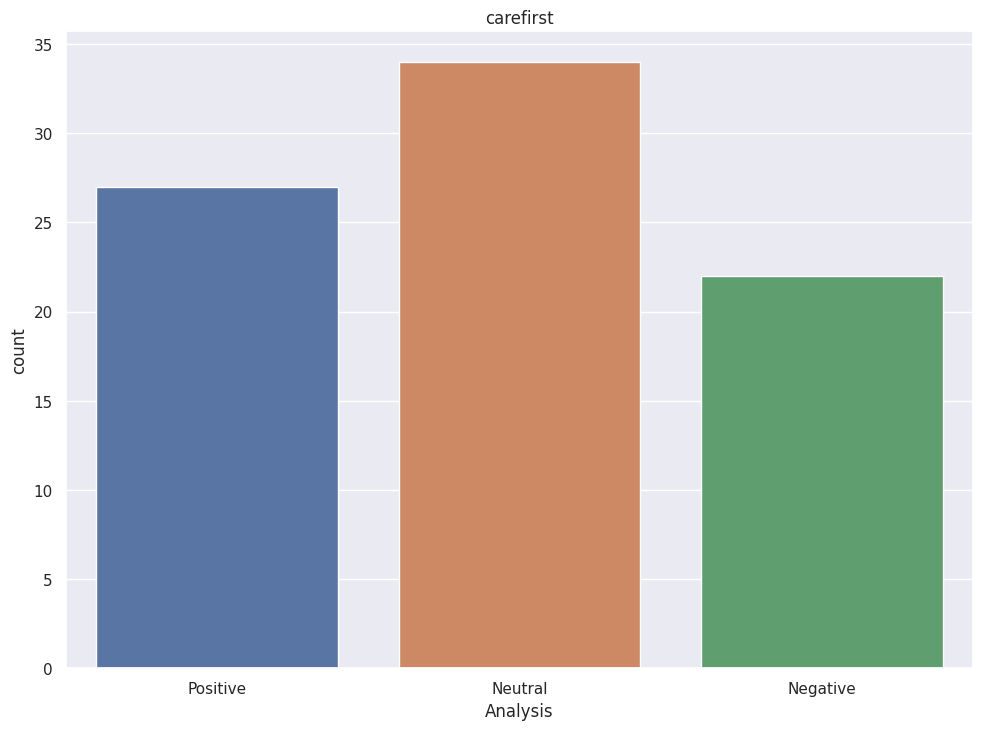

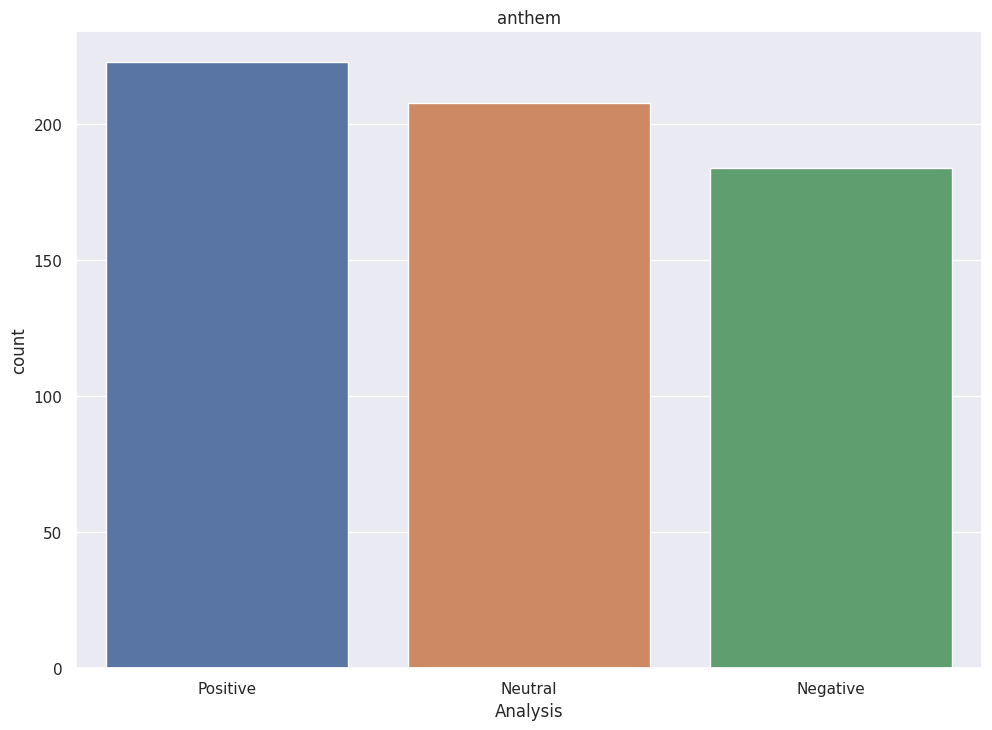

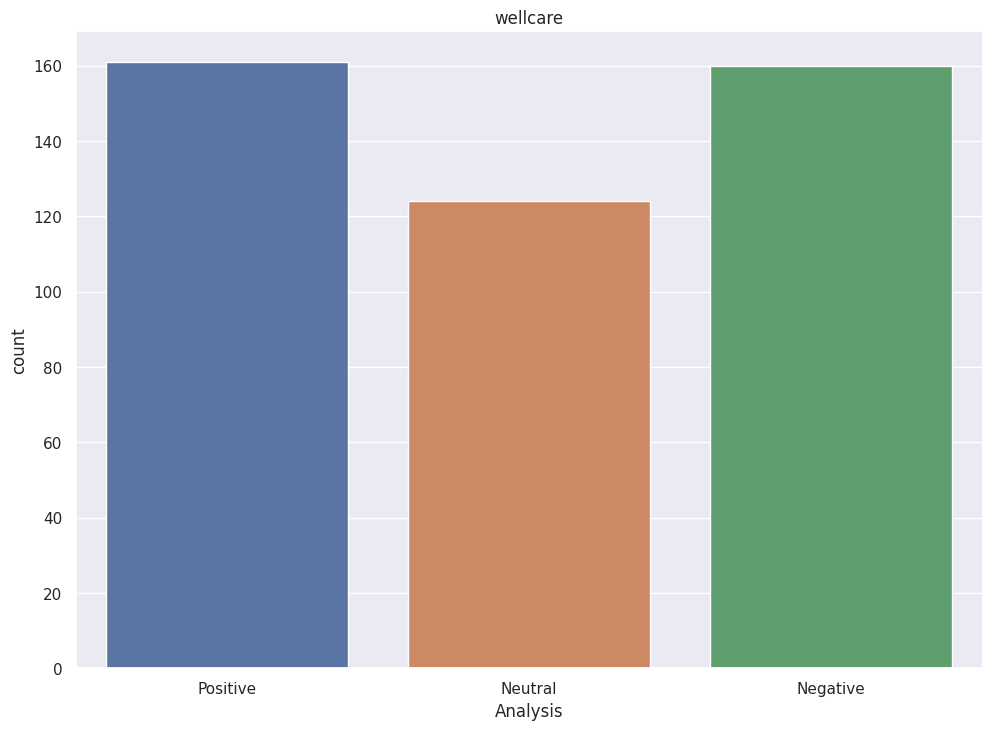

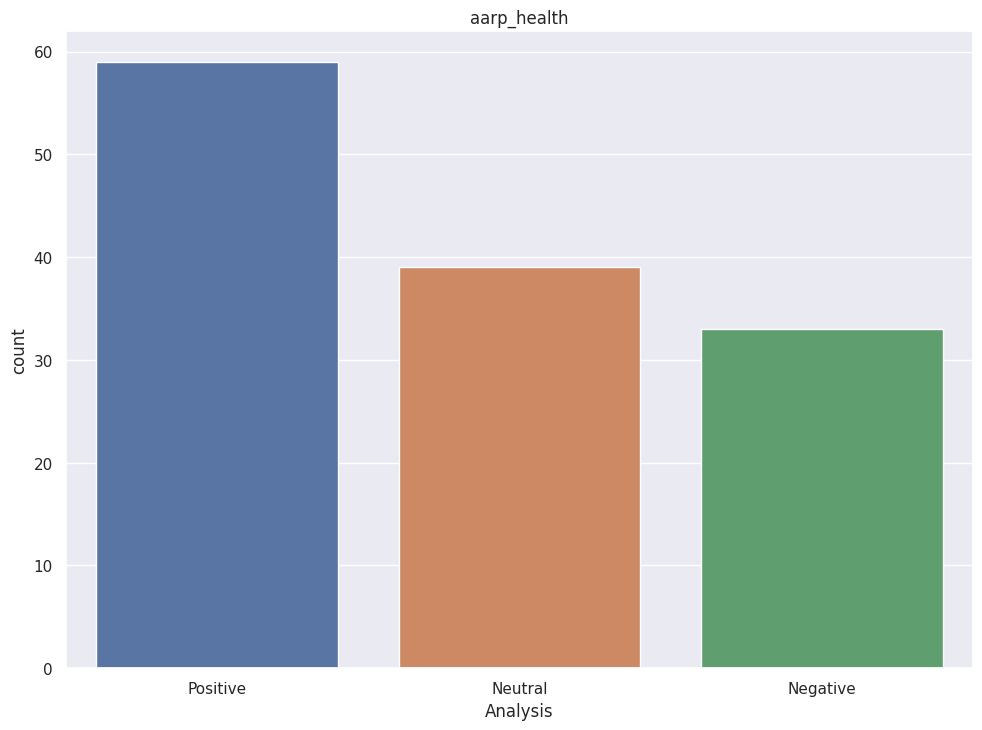

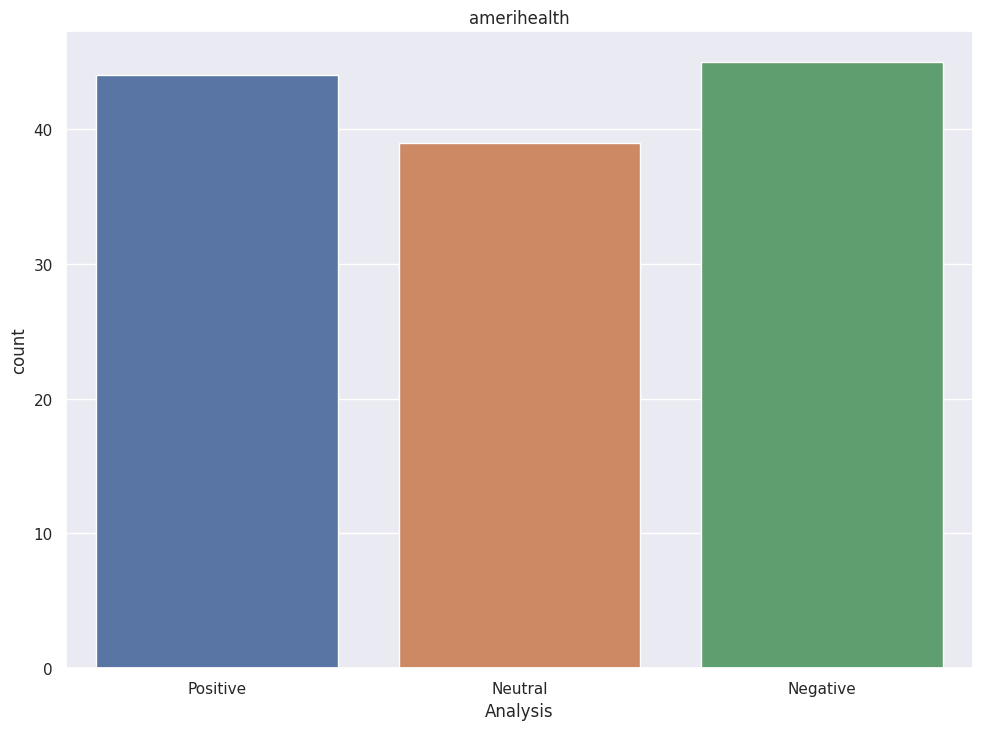

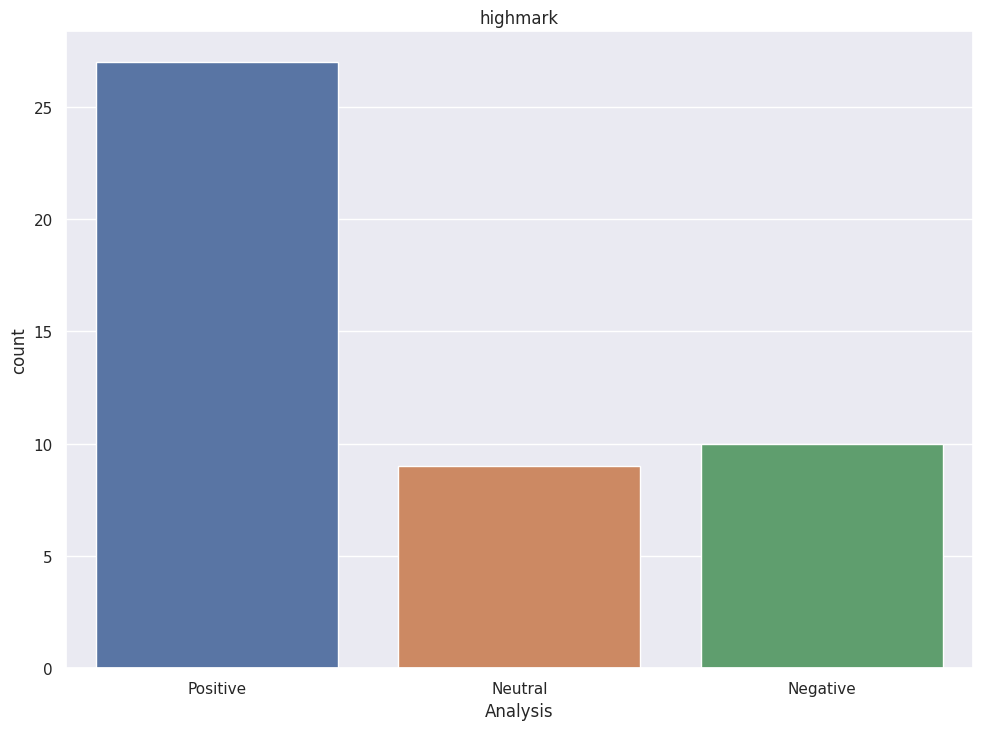

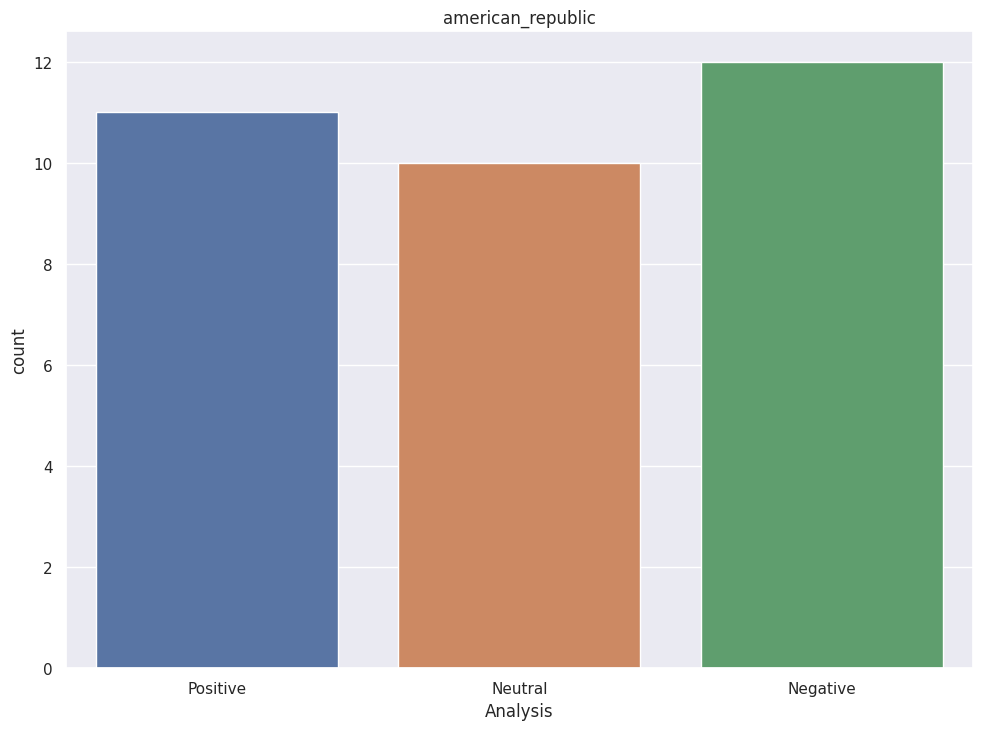

In [ ]:
#loop through all companies comparing analysis count
for company_name in reviews_df['CompanyName'].unique():
    sns.countplot(x='Analysis', data=reviews_df[reviews_df['CompanyName'] == company_name], order=reviews_df['Analysis'].value_counts().index)
    plt.title(company_name)
    plt.show()

This reiterates and highlights who our best and worst performing companies are.

## Word Clouds

In [ ]:
#wordcloud function
def create_wordcloud(text):
    allWords = ' '.join([reviews for reviews in text])
    wordCloud = WordCloud(background_color='white', width=800, height=500, random_state=42, max_font_size=130).generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()

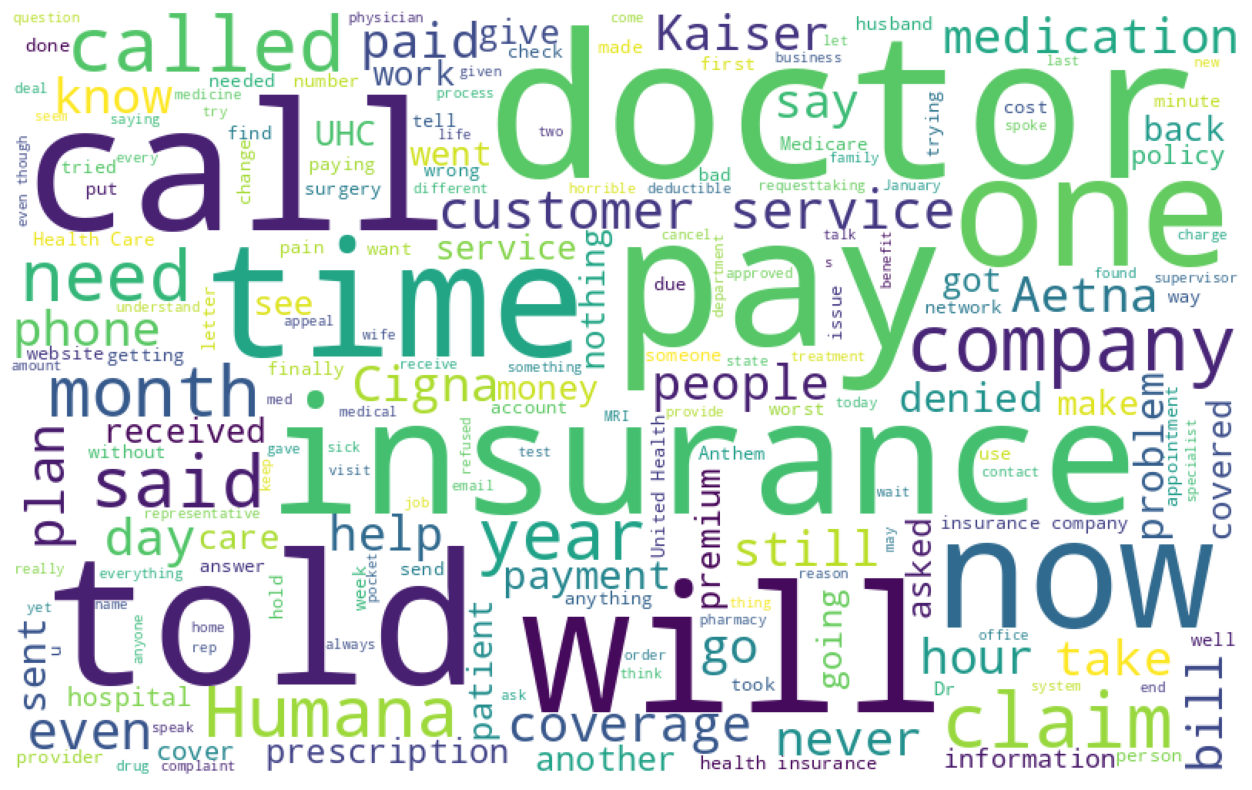

In [ ]:
#wordcloud for negative reviews
neg_reviews = reviews_df.loc[reviews_df['Analysis']=='Negative', 'Review']
create_wordcloud(neg_reviews)

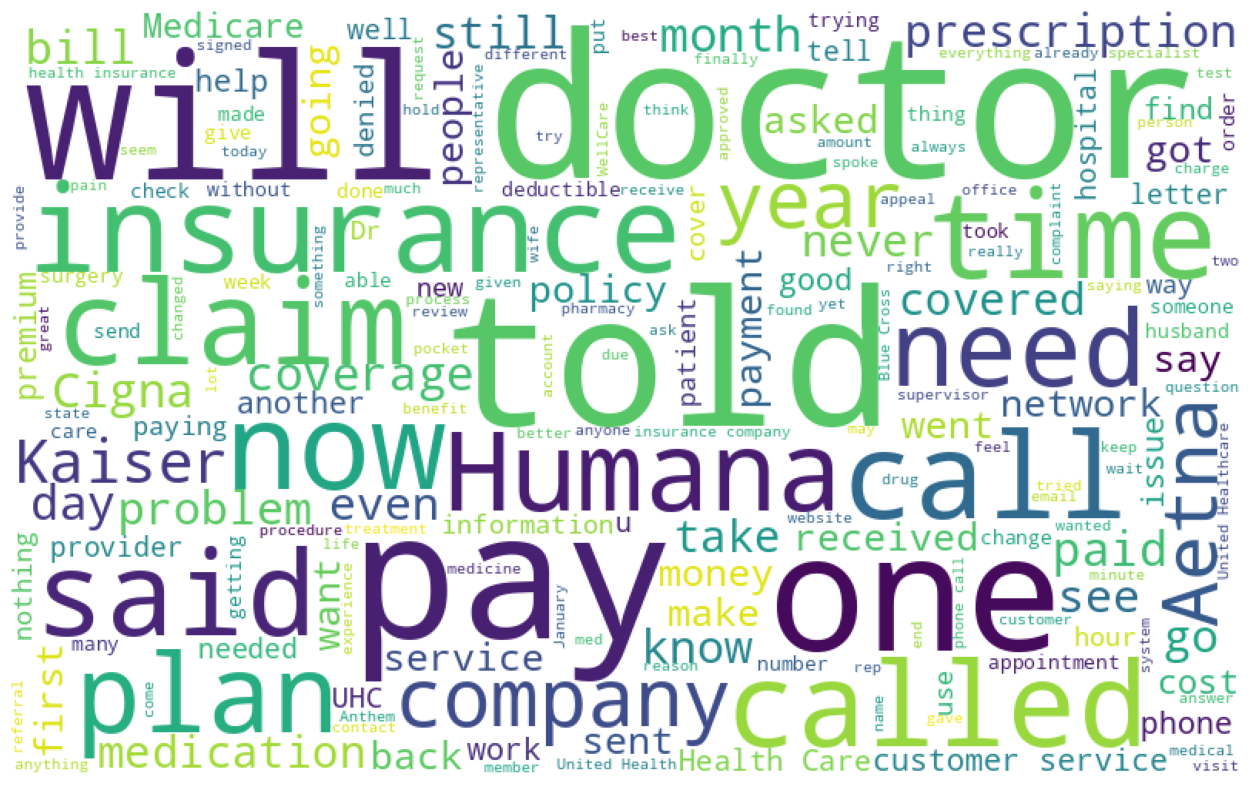

In [ ]:
#wordcloud for positive reviews
pos_reviews = reviews_df.loc[reviews_df['Analysis']=='Positive', 'Review']
create_wordcloud(pos_reviews)

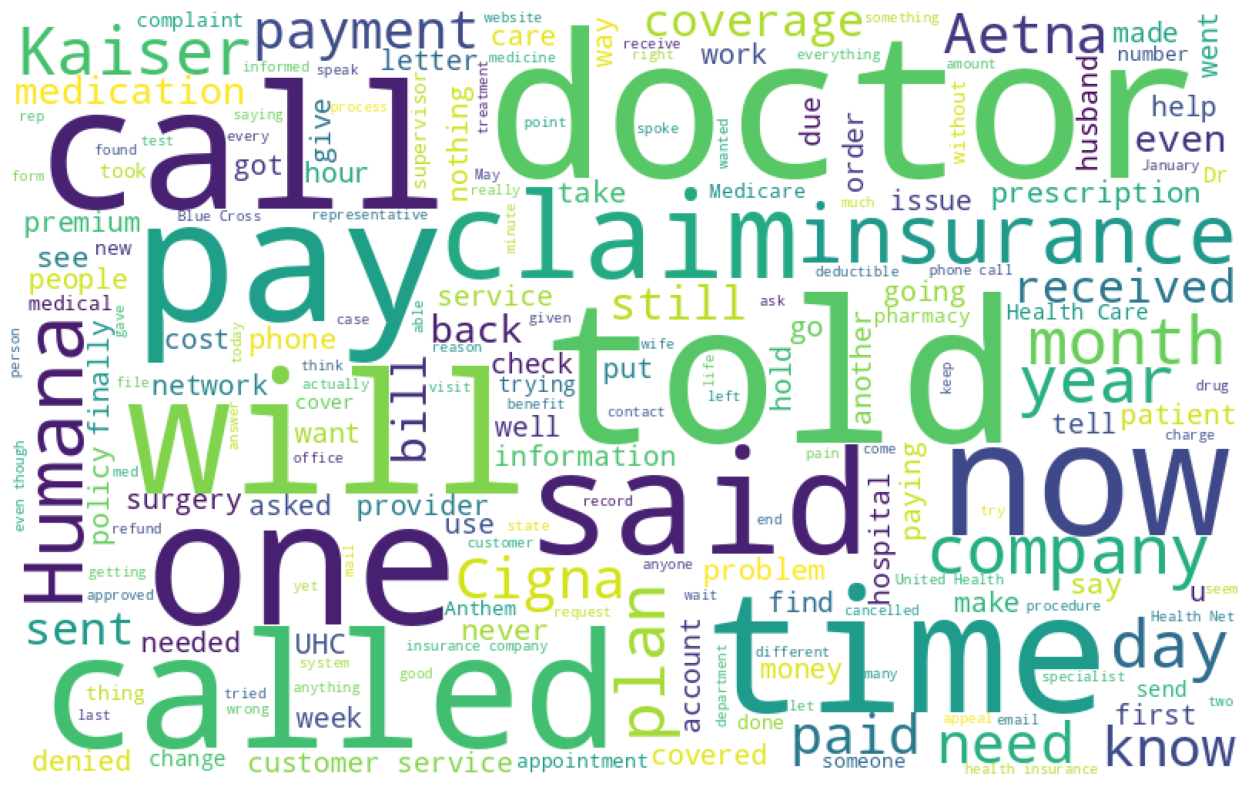

In [ ]:
#wordcloud for positive reviews
pos_reviews = reviews_df.loc[reviews_df['Analysis']=='Neutral', 'Review']
create_wordcloud(pos_reviews)

Our reviews are unified in the most important parts of their visit/customer service. They are pay, doctor, claim, insurance, called, coverage, and time. These obviously reflect the most important things to customers.

# Conclusions about Sentiment Analysis

For the most part finding the perfect company does not exist, but what we can do is avoid companies with a bad reputation. Our problem is simple: without a centralized website, is it difficult to come to conclusions on what companies provide excellent care, insurance, and customer service. Until that problem is satisfied, webscraping and sentiment analysis are our best bet on determining this. I may have only have scraped one website, but with enough work anyone can put together even more data on these companies. Ultimately despite the amount of data we collected there are some general recommendations that can be made when deciding a provider.

Just because a company is small doesn't mean that their service is poor. At the top of our list of companies, we find some smaller corporations. Being a small company does not default that company to providing poor service.

Non-profits and publicly traded companies typically are better choices. Whether because non-profits are subject to different rules and publicly traded companies rely more on public perception when determining their companies value, private companies typically perform worse when it comes to the service they provide for customers.

Lastly and most importantly, times change. Whether through market conditions or shifts in law. The quality of service might shift for better or worse among these competitors. Keeping your finger on the pulse might just be the difference in receiving the support necessary in a time of need or adding undo stress in an already stressful situation.

# Comparing Sk-LLM

## Polarization

In [ ]:
#analysis for original reviews
reviews_df['Analysis'][:500].value_counts()

Positive    316
Neutral     106
Negative     78
Name: Analysis, dtype: int64

In [ ]:
#analysis for llm45 reviews
reviews_llm45_df['Analysis'].value_counts()

Positive    249
Neutral     134
Negative    117
Name: Analysis, dtype: int64

In [ ]:
#analysis for llm90 reviews
reviews_llm90_df['Analysis'].value_counts()

Positive    245
Negative    130
Neutral     125
Name: Analysis, dtype: int64

It seems our chat model has redirected some of our positive reviews into neutral and negative reviews. Let's explore more to see this affect.

### DataFrame for Comparison

In [ ]:
#create new dataframe for comparing
review_difference_df = pd.DataFrame()

review_difference_df['ReviewOriginal'] = reviews_df['Review'][:498]
review_difference_df['Review90'] = reviews_llm90_df['Review']
review_difference_df['Review45'] = reviews_llm45_df['Review']

review_difference_df['AnalysisOriginal'] = reviews_df['Analysis'][:498]
review_difference_df['Analysis90'] = reviews_llm90_df['Analysis']
review_difference_df['Analysis45'] = reviews_llm45_df['Analysis']

review_difference_df['PolarityOriginal'] = reviews_df['Polarity'][:498]
review_difference_df['Polarity90'] = reviews_llm90_df['Polarity']
review_difference_df['Polarity45'] = reviews_llm45_df['Polarity']

review_difference_df['SubjectivityOriginal'] = reviews_df['Subjectivity'][:498]
review_difference_df['Subjectivity90'] = reviews_llm90_df['Subjectivity']
review_difference_df['Subjectivity45'] = reviews_llm45_df['Subjectivity']

In [ ]:
#check shape and columns
review_difference_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ReviewOriginal        498 non-null    object 
 1   Review90              498 non-null    object 
 2   Review45              498 non-null    object 
 3   AnalysisOriginal      498 non-null    object 
 4   Analysis90            498 non-null    object 
 5   Analysis45            498 non-null    object 
 6   PolarityOriginal      498 non-null    float64
 7   Polarity90            498 non-null    float64
 8   Polarity45            498 non-null    float64
 9   SubjectivityOriginal  498 non-null    float64
 10  Subjectivity90        498 non-null    float64
 11  Subjectivity45        498 non-null    float64
dtypes: float64(6), object(6)
memory usage: 50.6+ KB


In [ ]:
#preview new dataframe
review_difference_df.head()

,ReviewOriginal,Review90,Review45,AnalysisOriginal,Analysis90,Analysis45,PolarityOriginal,Polarity90,Polarity45,SubjectivityOriginal,Subjectivity90,Subjectivity45
0,"I've been with United American Insurance for lots of years and I just pay my bill every month. Once a year, I get a letter that they're increasing their rates, which I would prefer they didn't, but I can understand that it has to. A lot of my friends have HMOs but I like that with my insurance, I can go to whichever doctor I want. I've not had one doctor say they don't accept this insurance. Whatever Medicare paid, United American Insurance paid the other 20%. I am pleased with the service I'm getting, where everything is covered and the choices are mine. Others have to go for a second opinion but I don't. If I feel I need to see a special doctor, I can make an appointment and go. So, the flexibility is worth the money.","The author has been with United American Insurance for many years and is satisfied with the service. They appreciate the flexibility to choose their own doctors and have not encountered any issues with coverage. While they receive annual rate increases, they understand the necessity and feel the flexibility is worth the cost.","A satisfied customer of United American Insurance praises the flexibility of their coverage, which allows them to see any doctor they choose without needing a second opinion. They are willing to pay for this service despite annual rate increases.",Positive,Positive,Positive,0.147449,0.380000,0.187500,0.292347,0.520000,0.437500
1,"United American has been fantastic. We have had not one bit of trouble collecting or paying for anything at all. So, we're extremely happy. I've had a lot of illnesses so many times and when you had as much as I've had, you get canceled pretty quickly by other companies. But United have not questioned and they have been unbelievable. We are very fortunate to have gotten them. We pay quite a bit, but it's worth the cost. When I was very ill on sepsis and pancreatic stones, I was in the hospital for 15 days and they were no questions asked. In the last few years, I've had treatments for my breast cancer and there were no questions about that either.","The speaker praises United American for their excellent service, particularly in regards to their willingness to cover medical expenses without question. Despite paying a high cost, the speaker believes it is worth it and has had positive experiences with the company during multiple illnesses, including sepsis and breast cancer treatments.","United American provides excellent service with no issues in collecting or paying for medical expenses. They have been accommodating and understanding, covering treatments for various illnesses without questioning. Despite the high cost, the service is worth it.",Positive,Positive,Positive,0.110357,0.231742,0.243333,0.525119,0.314848,0.356667
2,"We've had very good luck with United American. We got it in 2001 and we have used it. My husband had open heart surgery quite a few years ago. Now, there was a discrepancy. I was just hospitalized from an accident on the farm here and we had a little problem, but it was more of the hospital. They kept saying I still owed $1,500. When we called United American, they said no, they had mailed a check. Somewhere, the check must have gotten lost, so they were going to rebill them again. But that was the only time that I had a problem. We're very satisfied with what we've got and our experience with it has been very good.","The speaker has had a positive experience with United American insurance since 2001, except for one issue with a hospital bill that was resolved by the insurance company. The speaker's husband had open heart surgery and the speaker was recently hospitalized due to an accident on their farm. Overall, they are satisfied with their insurance.","A satisfied customer of United American shares positive experience with the insurance company, except for one issue with

### Average Polarization Difference (APD)

In [ ]:
#APD llm90
(review_difference_df['PolarityOriginal']-review_difference_df['Polarity90']).mean()

0.08939444199305317

In [ ]:
#APD llm45
(review_difference_df['PolarityOriginal']-review_difference_df['Polarity45']).mean()

0.08281142580898505

It seems what's actually occuring is our model is affecting the overall score in a more positive light, but what about reviews that we're already negative to begin with?

### APD LLM90 Split

In [ ]:
#APD llm90 for negative reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'PolarityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'Polarity90']).mean()

-0.05380445752947826

In [ ]:
#APD llm90 for positive reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'PolarityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'Polarity90']).mean()

0.14466503130689307

In [ ]:
#APD llm90 for neutral reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'PolarityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'Polarity90']).mean()

0.02916877811923575

### APD LLM45 Split

In [ ]:
#APD llm45 for negative reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'PolarityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'Polarity45']).mean()

-0.023230304590065573

In [ ]:
#APD llm45 for positive reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'PolarityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'Polarity45']).mean()

0.13131823508764012

In [ ]:
#APD llm45 for neutral reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'PolarityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'Polarity45']).mean()

0.015694145789650588

It seems what's happening is our chat model is cutting through the noise. Doing this ultimately creates a more polarizing effect. Another interesting effect is the diminishing polarizing effect as we cut down on the words even further.

Let's inspect subjectivity. I would expect to see a drastic decrease in subjectivity.

## Subjectivity

In [ ]:
#subjetivity llm90
(review_difference_df['SubjectivityOriginal']-review_difference_df['Subjectivity90']).mean()

0.05775230679360785

In [ ]:
#subjetivity llm45
(review_difference_df['SubjectivityOriginal']-review_difference_df['Subjectivity45']).mean()

0.06945165244383822

It seems it may be the oppsite of what I expected. Subjectivity is increasing as well.

### Subjectivity LLM90 Split

In [ ]:
#subjetivity llm90 for negative reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'SubjectivityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'Subjectivity90']).mean()

0.08052004390585606

In [ ]:
#subjetivity llm90 for neutral reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'SubjectivityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'Subjectivity90']).mean()

-0.01259830305970621

In [ ]:
#subjetivity llm90 for positive reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'SubjectivityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'Subjectivity90']).mean()

0.0758603984977608

### Subjectivity LLM45 Split

In [ ]:
#subjetivity llm45 for negative reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'SubjectivityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Negative', 'Subjectivity45']).mean()

0.06802259291837724

In [ ]:
#subjetivity llm45 for neutral reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'SubjectivityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Neutral', 'Subjectivity45']).mean()

0.013529496333423372

In [ ]:
#subjetivity llm45 for positive reviews
(review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'SubjectivityOriginal'] - review_difference_df.loc[review_difference_df['AnalysisOriginal'] == 'Positive', 'Subjectivity45']).mean()

0.08861922746340795

The difference in neutral reviews is negligable. In enhancing the negatives and positives of reviews. Our model has nothing to enhance for these.

# Conclusions on Sk-LLMs Use Case

The use of cutting down on the amount of information we feed our sentiment analysis is an interesting case. While we do want to ensure that we provide the best information possible to our sentiment analysis the question must be asked. Are we capturing the essence of what was said when we use an LLM to transform a person's speech, or are we twisting it to fufill what an algorithm believes to be their point?

Since thats a very difficult question to answer since it's on a person by person basis we can only use the conclusions found here to determine whether these models are valid in their use.

In my opinion, the use of an LLM to cut down on lengthy amounts of information might be valid. Perhaps a reduction in noise is just what sentiment analysis needs to come to more solid conclusions.

Doing so gives us the essence of what was said. In the same way that we as people qualify our statements, someone might hesitate to call a service bad if they found one or two things they felt were acceptable from their perspective. But that doesn't mean that the service they recieved was acceptable. A nice doctor does not mean that poor customer service and lack luster coverage is acceptable. While I would not use LLMs to oversimplify shorter reviews.

When a review is sufficiently lengthy, it can be used as a tool to cut down on the fat.

The use of these models to provide more direct information about reviews will most definitely become the norm. Why host so much data when you can host much less by using one of these models to translate it.